In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))
print(sys.path[-1])

/Users/hawkins/code/hBN_PL/src


In [2]:
#import modules
import hbn_pl.io as io
import numpy as np
import hbn_pl.preprocess as preprocess
import hbn_pl.plot as plot
import hbn_pl.peaks2 as peaks2
import hbn_pl.classification2 as classification
import csv

SyntaxError: duplicate argument 'drop_fraction' in function definition (io.py, line 60)

Performing background subtraction...
Successfully subtracted background.


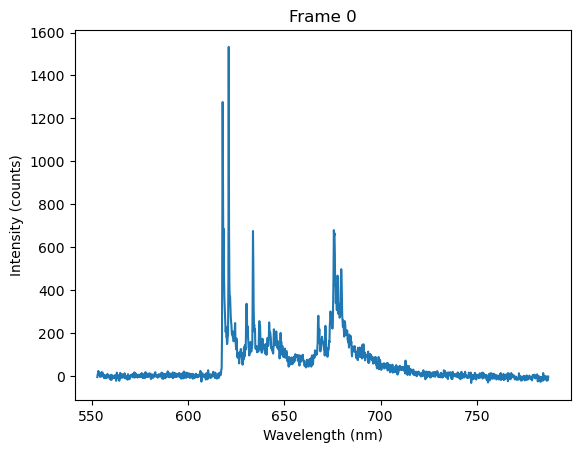

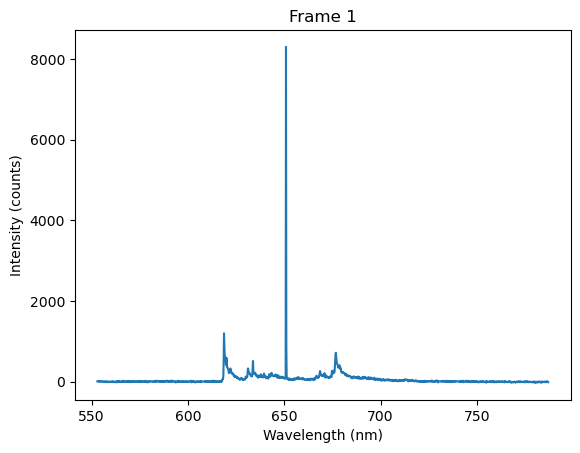

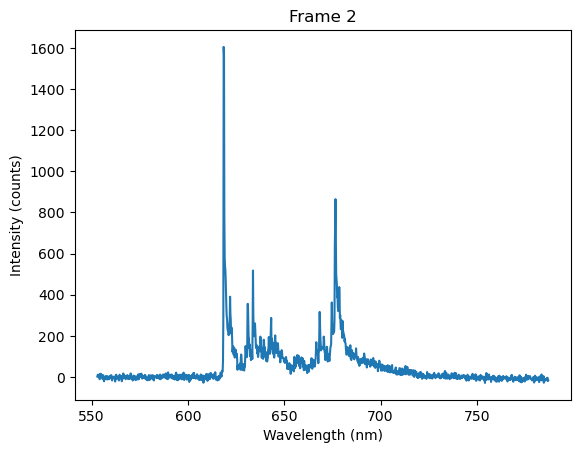

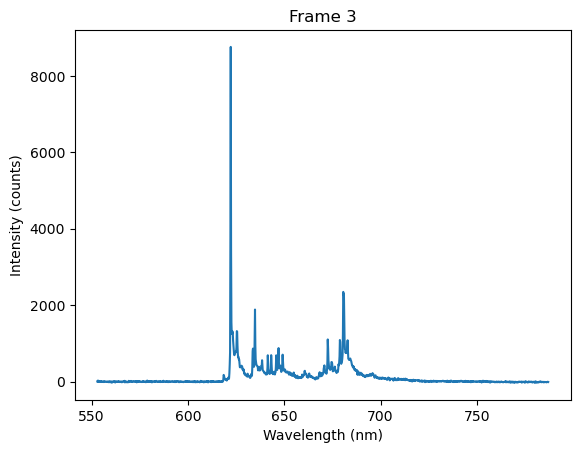

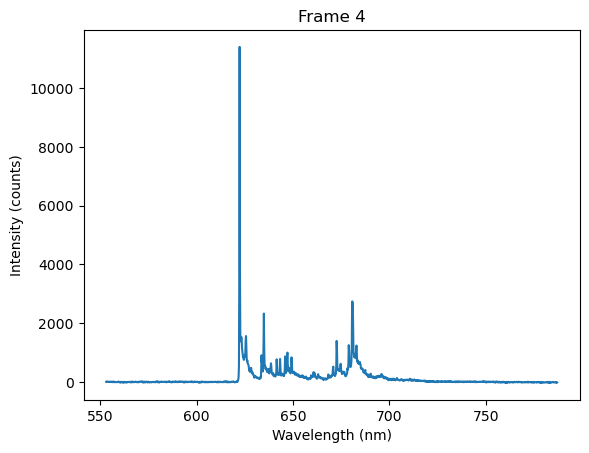

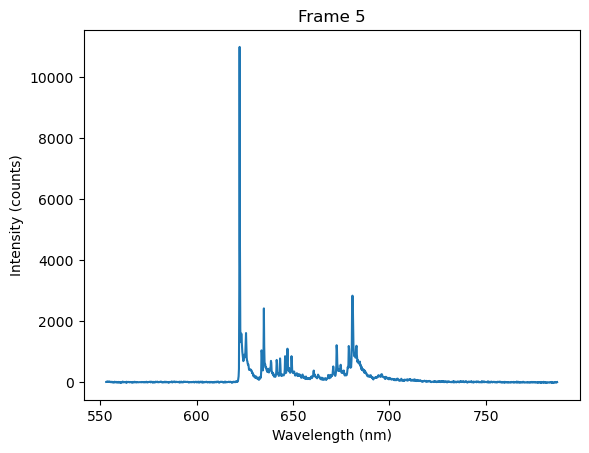

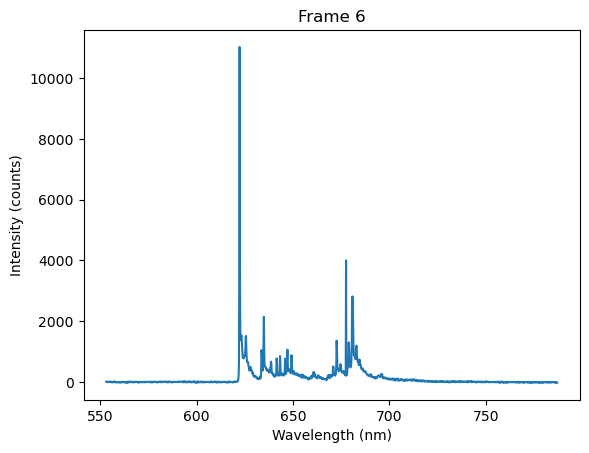

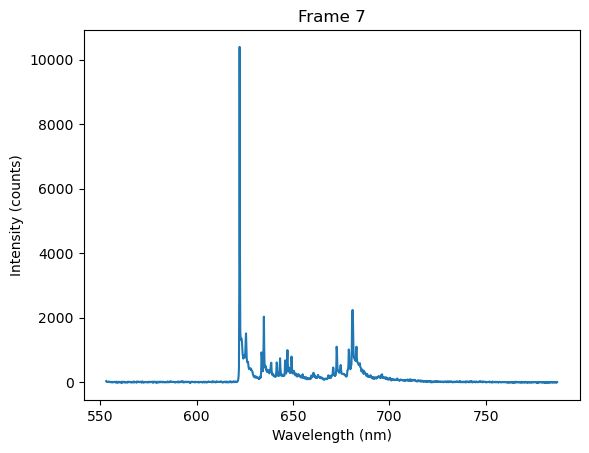

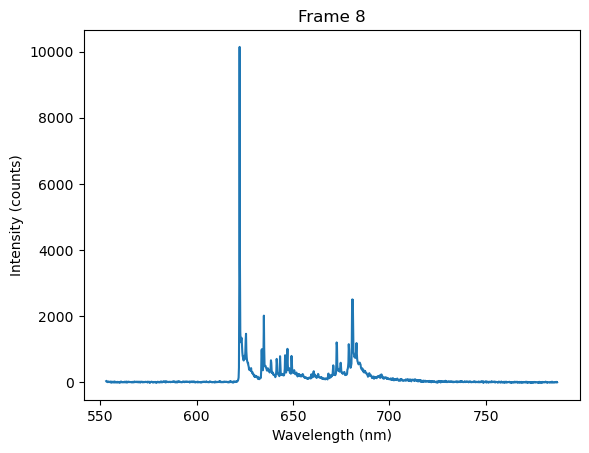

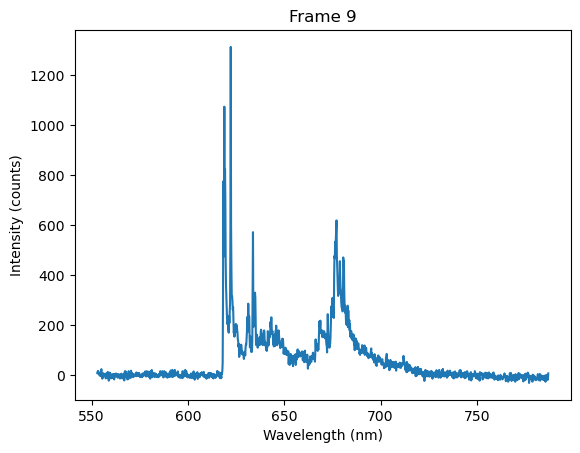

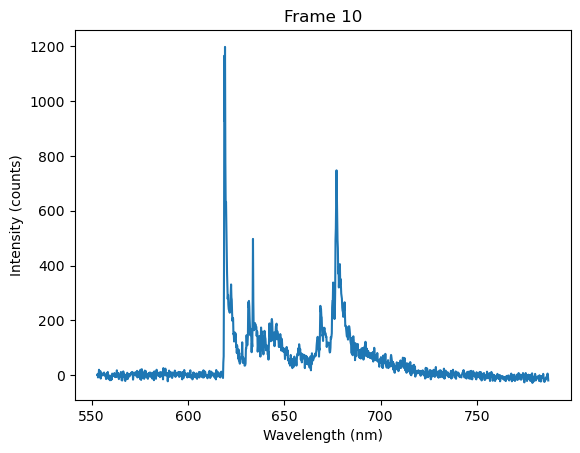

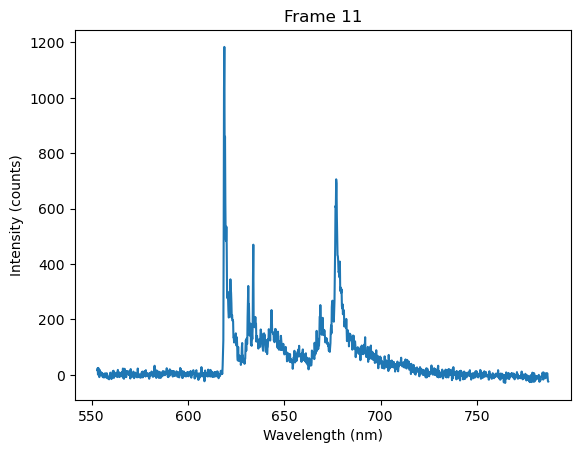

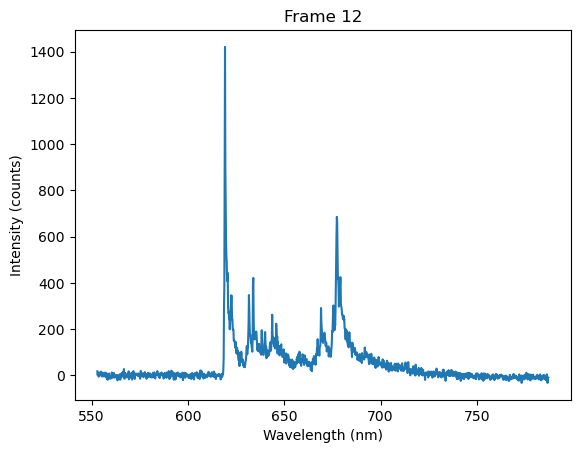

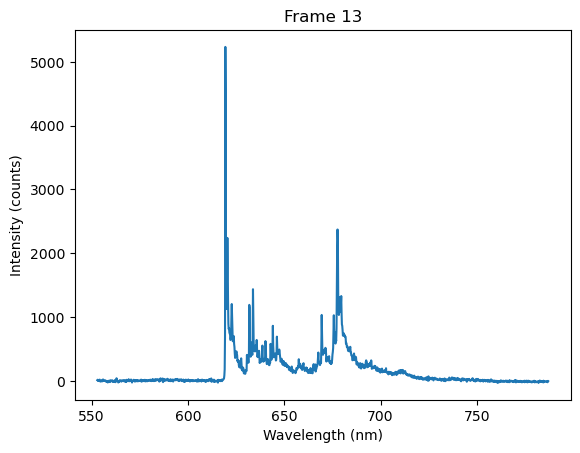

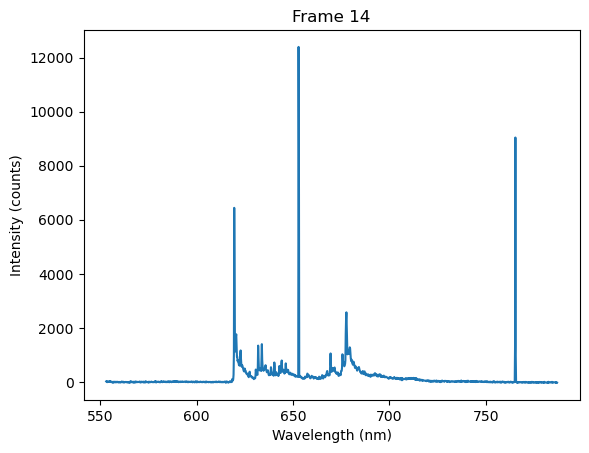

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [ ]:
# load test emitter data
DATA_DIR = Path("/Users/hawkins/code/hBN_PL/data/All data")
#FILE_NAME = '2025-11-20 18_51_06 sample3_DCMd2_200uw_emitter14 2231.spe' 
FILE_NAME = '2025-11-17 17_34_30 sample5_DCMd2_200uw_emitter11 2189.spe' # good example, lots of cosmic rays removal
#FILE_NAME = '2025-11-17 17_59_53 sample5_DCMd2_200uw_emitter17 2195.spe'
spe_path = DATA_DIR / FILE_NAME
wavelength, frames = io.load_spe(spe_path)
frames = frames[0:15]

# pre-process and plot for visual check
frames = preprocess.background_subtract(frames, bg_slice=(1, 50))
plot.plot_frames(wavelength, frames)

Detecting cosmic ray frames...
Detected 2 cosmic ray frames: [1, 14]
Cosmic ray wavelengths: {1: [650.9426357271755], 14: [652.8659643784006, 765.4112890047277]}
Cosmic ray detection complete.


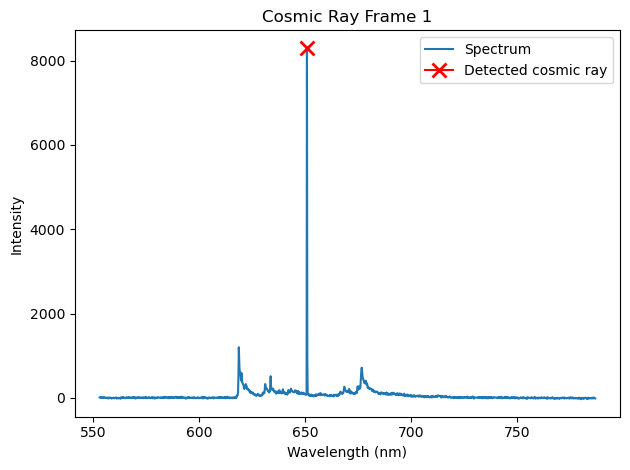

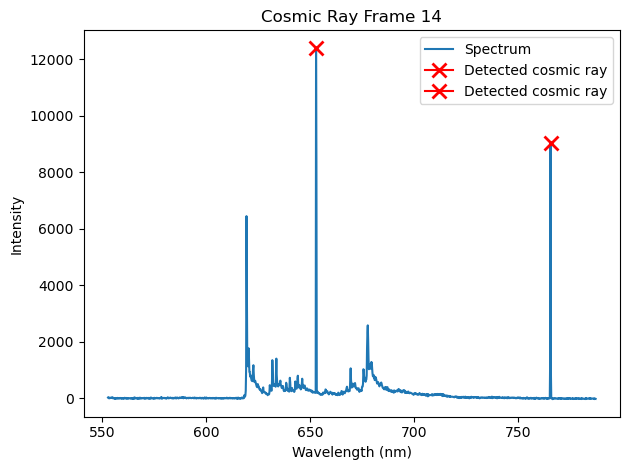

Removing cosmic rays from 2 frames: [1, 14]


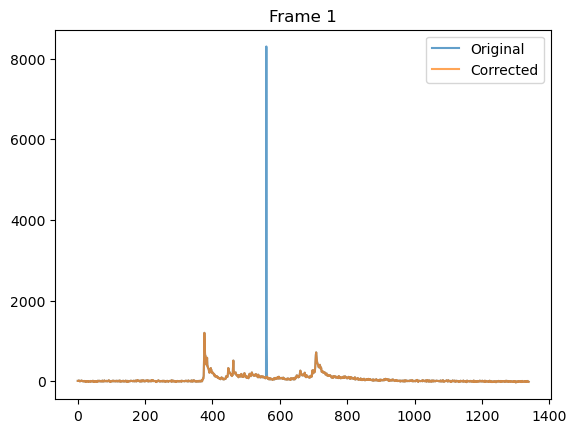

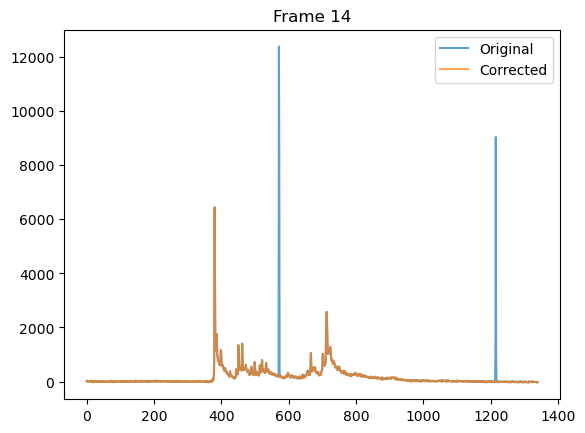

Cosmic ray removal complete.


In [ ]:
# Cosmic ray removal
cosmic_frames, cosmic_location = preprocess.detect_cosmic_frames(frames, wavelength,
prominence_threshold=0.05, fwhm_threshold=1.9, n_peaks=3, z_thresh=100, half_width=5, noise_width=30)
plot.plot_cosmic_frames(frames, wavelength, cosmic_location)
frames_cleaned = preprocess.remove_cosmic_rays2(frames, wavelength, cosmic_frames, cosmic_location, sigma=1.5, half_width = 5)

In [ ]:
#bad frame removal

drop_fraction = 0.6
bad_frames = preprocess.detect_bad_frames_simple(frames, drop_fraction = drop_fraction)
#bad_frames = preprocess.detect_bad_frames_complex(frames, window = 5, drop_fraction = drop_fraction)
frames = preprocess.remove_frames(frames, bad_frames)

Running simple bad frame detection...
Detected bad frames due to intensity drop 0.6: [ 0  1  2  9 10 11 12]
Removing 7 frames: [ 0  1  2  9 10 11 12]
Successfully removed bad frames.


Averaging and normalising frames into a single spectrum...
Successfully averaged and normalised frames.


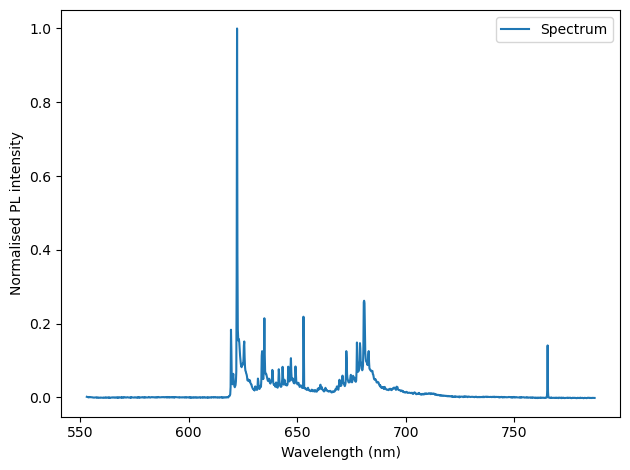

In [ ]:
# average and normalise
avg, avg_norm = preprocess.average_and_normalise(frames)
plot.plot_spectrum(wavelength, avg_norm)

Detected peaks:
{'location': np.float64(619.4671486652222), 'intensity': np.float64(0.18365904007708483), 'fwhm': np.float64(0.3497530402122493), 'prominence': np.float64(0.15590148713710952)}
{'location': np.float64(622.2651575423462), 'intensity': np.float64(1.0), 'fwhm': np.float64(0.1748746357637856), 'prominence': np.float64(1.0013997147606575)}
{'location': np.float64(634.855780407803), 'intensity': np.float64(0.21469237862172608), 'fwhm': np.float64(0.34972955654825455), 'prominence': np.float64(0.18896723576276003)}
{'location': np.float64(652.8659643784006), 'intensity': np.float64(0.21886663624964503), 'fwhm': np.float64(0.34969404072455745), 'prominence': np.float64(0.19997351804761007)}
{'location': np.float64(680.8387964790663), 'intensity': np.float64(0.2622038727462423), 'fwhm': np.float64(0.6992471195896997), 'prominence': np.float64(0.24856375290743124)}
{'location': np.float64(765.4112890047277), 'intensity': np.float64(0.14107223191809098), 'fwhm': np.float64(0.17464

/var/folders/8g/5d8vd9052js99py85nx9jxz00000gn/T/ipykernel_11819/3442268719.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


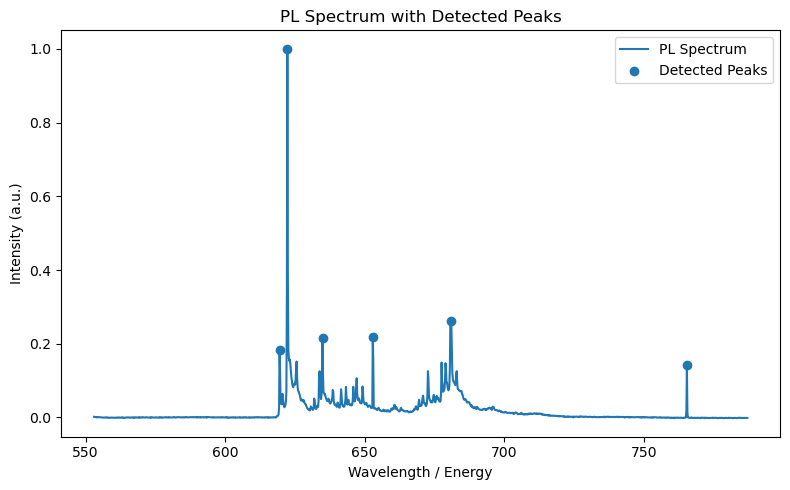

In [ ]:
# peak detection
finder = peaks2.PeakFinder(wavelength, avg_norm)
finder.peak_finding(prominence=0.1)
peaks = finder.extract_peak_parameters()

print("Detected peaks:")
for p in peaks:
    print(p)

fig = finder.plot_peaks()
fig.show()

In [ ]:
#classify peaks
classifier = classification.ZPLClassification(peaks, thresholds={
            "max_fwhm": 0.9,           
            "min_prominence": 0.7,   
            "location_range": [615, 660]    
        })

msg, zpl_peaks = classifier.classify()

print(msg)

Single ZPL
Peak 1: location = 622.3, prominence = 1.0


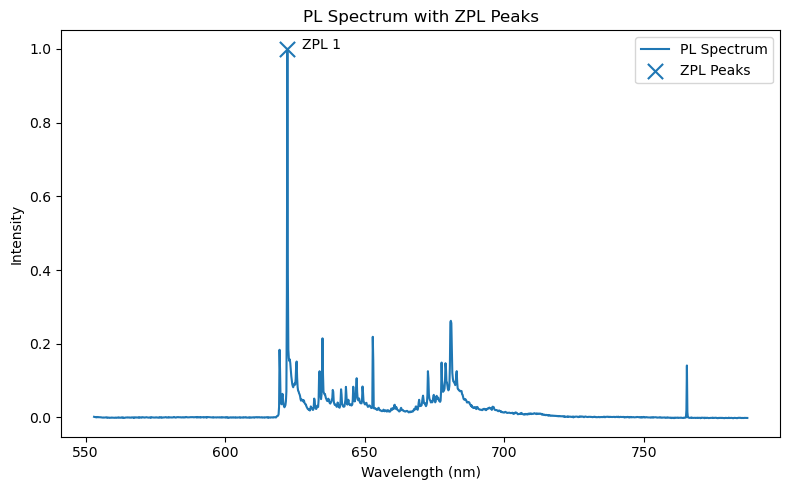

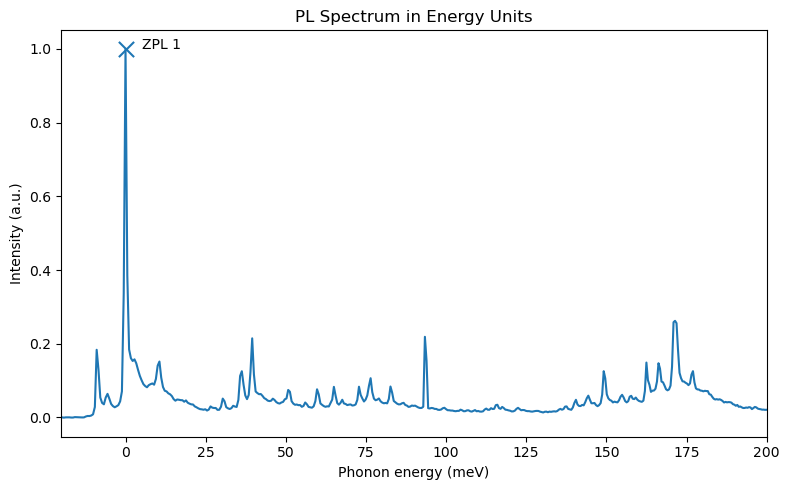

In [ ]:
# plot final wavelength and energy plots
zpl_fig = finder.plot_zpl_on_spectrum(zpl_peaks)
energy_fig = finder.plot_energy(zpl_peaks)


In [ ]:
# save outputs
OUTPUT_DIR = Path("/Users/hawkins/code/hBN_PL/output") # Main directory of all outputs
io.output(peaks, 
               msg, 
               OUTPUT_DIR, 
               FILE_NAME, 
               wavelength, 
               frames, 
               plot, 
               finder=finder,
               zpl_peaks = zpl_peaks,
               bad_frames=bad_frames,
               drop_fraction=drop_fraction)

NameError: name 'preprocess' is not defined